In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import os
from tqdm import tqdm
import datetime
from chinese_calendar import is_holiday, is_workday
import pickle
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import folium


"""
 聚类特征分析
 特征提取 (ExtractFeature)

为每个地铁站点提取时间流量特征
将一天分成8个时段（每2小时一段，6:00-22:00）
分别统计工作日和非工作日的进出站客流量
每个站点最终有32个特征：工作日8时段进站+8时段出站+非工作日8时段进站+8时段出站

计算每个聚类的平均时间流量模式
绘制各聚类在工作日/非工作日的典型流量曲线
分析不同类型站点的客流特征
实际应用价值
这种分析可以识别出：

商务区站点：工作日早晚高峰明显的双峰模式
居住区站点：与商务区相反的流量模式
混合功能站点：流量相对均匀
旅游/商业站点：周末客流更高
对地铁运营管理、站点功能定位、城市规划都有重要指导意义。
"""

'\n 聚类特征分析\n 特征提取 (ExtractFeature)\n\n为每个地铁站点提取时间流量特征\n将一天分成8个时段（每2小时一段，6:00-22:00）\n分别统计工作日和非工作日的进出站客流量\n每个站点最终有32个特征：工作日8时段进站+8时段出站+非工作日8时段进站+8时段出站\n\n计算每个聚类的平均时间流量模式\n绘制各聚类在工作日/非工作日的典型流量曲线\n分析不同类型站点的客流特征\n实际应用价值\n这种分析可以识别出：\n\n商务区站点：工作日早晚高峰明显的双峰模式\n居住区站点：与商务区相反的流量模式\n混合功能站点：流量相对均匀\n旅游/商业站点：周末客流更高\n对地铁运营管理、站点功能定位、城市规划都有重要指导意义。\n'

In [2]:
root_path = '../Data' 
raw_data = pd.read_csv(os.path.join(root_path, 'metroData_InOutFlow.csv'))
raw_data

,date,timeslot,startTime,endTime,station,inFlow,outFlow,CinFlow,HBOinFlow,NHBinFlow,CoutFlow,HBOoutFlow,NHBoutFlow
0,20170501,0,60000,61000,112,29,32,9,15,5,11,13,8
1,20170501,0,60000,61000,113,142,102,40,51,51,30,41,31
2,20170501,0,60000,61000,114,66,35,17,19,30,12,10,13
3,20170501,0,60000,61000,119,23,14,6,9,8,1,3,10
4,20170501,0,60000,61000,124,17,21,2,4,11,0,9,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3788887,20170831,12545,225000,230000,2053,6,26,2,0,4,8,6,12
3788888,20170831,12545,225000,230000,2054,18,110,5,2,11,19,39,52
3788889,20170831,12545,225000,230000,2055,5,80,0,1,4,19,23,38
3788890,20170831,12545,225000,230000,2056,33,99,8,4,21,20,31,48


In [3]:
stationInfo = pd.read_csv('../Data/stationInfo.csv')
dict_staionName = dict(zip(stationInfo['stationID'], stationInfo['name']))
dict_stationLoc = dict(zip(stationInfo['stationID'], zip(stationInfo['lon'],stationInfo['lat'])))
stationID_List = list(stationInfo['stationID'])

# with open('../../MetaData/travelDis.pkl', 'rb') as f:
#     travelDis = pickle.load(f)

# with open('../../MetaData/travelTime.pkl','rb') as f:
#     travelTime = pickle.load(f)

In [4]:
def ExtractFeature():
    abnormal_date = [20170504, 20170508, 20170509, 20170616, 20170627, 20170628]
    featureWorkday = np.zeros((len(stationID_List), 8*2)) #[wordayinflow, workdayoutflow]
    featureNonWorkday = np.zeros((len(stationID_List), 8*2)) #[non-wordayinflow, non-workdayoutflow]
    #每个站点有16个特征：工作日8个时间段进出站量，非工作日8个时间段进出站量
    workday_count = 0
    nonworkday_count = 0
    day_cache = 20170504

    for line in tqdm(raw_data.values):
        if line[0] in abnormal_date:
            continue 

        if line[0] != day_cache:
            day_cache = line[0]
            curr_date = datetime.datetime.strptime(str(line[0]),"%Y%m%d")
            if is_workday(curr_date):
                workday_count += 1
            else:
                nonworkday_count += 1
        
        curr_hour = line[2]//10000


        if curr_hour < 6 or curr_hour >= 22:
            continue
        #只分析6:00-22:00的运营时间

        stationID = line[4]
        time_bins = (curr_hour - 6) // 2  # 每2小时为一个时间段


        if is_workday(curr_date):
            featureWorkday[stationID_List.index(stationID), time_bins] += line[5]
            featureWorkday[stationID_List.index(stationID), time_bins + 8] += line[6]#+8就是outflow
        else:
            featureNonWorkday[stationID_List.index(stationID), time_bins] += line[5]
            featureNonWorkday[stationID_List.index(stationID), time_bins + 8] += line[6]
        
    featureWorkday = featureWorkday / workday_count
    featureNonWorkday = featureNonWorkday / nonworkday_count
    featureResult = np.concatenate((featureWorkday, featureNonWorkday), axis=1)
    print(featureResult.shape, workday_count, nonworkday_count)

    return featureResult
    

In [ ]:
featureResult = ExtractFeature()
#302x32，每个站点32个特征，一共有302个站点ID。每个特征的含义是前16个，每个点的工作日的每2个小时特征，前8个为入站，后8个为出站，后16个是非工作日特征

100%|██████████| 3788892/3788892 [02:08<00:00, 29557.49it/s] 

(302, 32) 81 36


In [ ]:
def ClusterAndVis(featureResult):
    featureResult = (featureResult - np.min(featureResult,axis=0))/(np.max(featureResult,axis=0)-np.min(featureResult,axis=0)) # norm
    #规范化
    # Find K 
    silhouette_scores = []
    inertia = []
    for k in range(3, 9):
        kmeans = KMeans(n_clusters=k, random_state=2025)
        kmeans.fit(featureResult)
        score = silhouette_score(featureResult, kmeans.labels_)
        silhouette_scores.append(score)
        inertia.append(kmeans.inertia_)
    # plt.figure(figsize=(10, 5))
    # plt.plot(list(range(3, 9)), inertia, 'bo-')
    # plt.xlabel('Number of clusters (k)')
    # plt.ylabel('Inertia')
    # plt.title('Elbow Method')
    # plt.show()

    best_k = np.argmax(silhouette_scores) + 3 
    for _ in range(len(silhouette_scores)):
        print(silhouette_scores[_])
    print(f"Best number of clusters (k) based on Silhouette Score: {best_k}")

    kmeans = KMeans(n_clusters=best_k, random_state=2025, init='k-means++', n_init=20)
    kmeans.fit(featureResult)
    cluster_labels = kmeans.labels_ 
    hue_order = ['Cluster A', 'Cluster B','Cluster C']
    cluster_labels_names = [hue_order[i] for i in cluster_labels]

    tsne = TSNE(n_components=2, random_state=2025, n_iter=5000, learning_rate=500)  
    X_tsne = tsne.fit_transform(featureResult)  
    plt.figure(figsize=(8, 6), dpi= 300)
    #plt.title('T-SNE Visualization of Station Clustering',fontsize=20)
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=cluster_labels_names, palette=['#D7592C','#1072BD','#EDB021','#7F318D','#77AE43'], legend='full',hue_order=hue_order)
    plt.rcParams['xtick.labelsize'] = 15  # x轴刻度标签大小
    plt.rcParams['ytick.labelsize'] = 15  # y轴刻度标签大小
    plt.legend(fontsize=15, loc='lower left')  # 你可以根据需要调整这个数值
    plt.savefig('../results/cluster-tSNE.pdf', dpi=300)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    # plt.subplots_adjust(right=0.75)


    return cluster_labels

0.44935583903506005
0.38389297876981504
0.3911197377699553
0.37950167146429337
0.3754404414302607
0.33880670767562515
Best number of clusters (k) based on Silhouette Score: 3


h:\Miniconda3\envs\p4\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24680\732832478.py:35: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=cluster_labels_names, palette=['#D7592C','#1072BD','#EDB021','#7F318D','#77AE43'], legend='full',hue_order=hue_order)


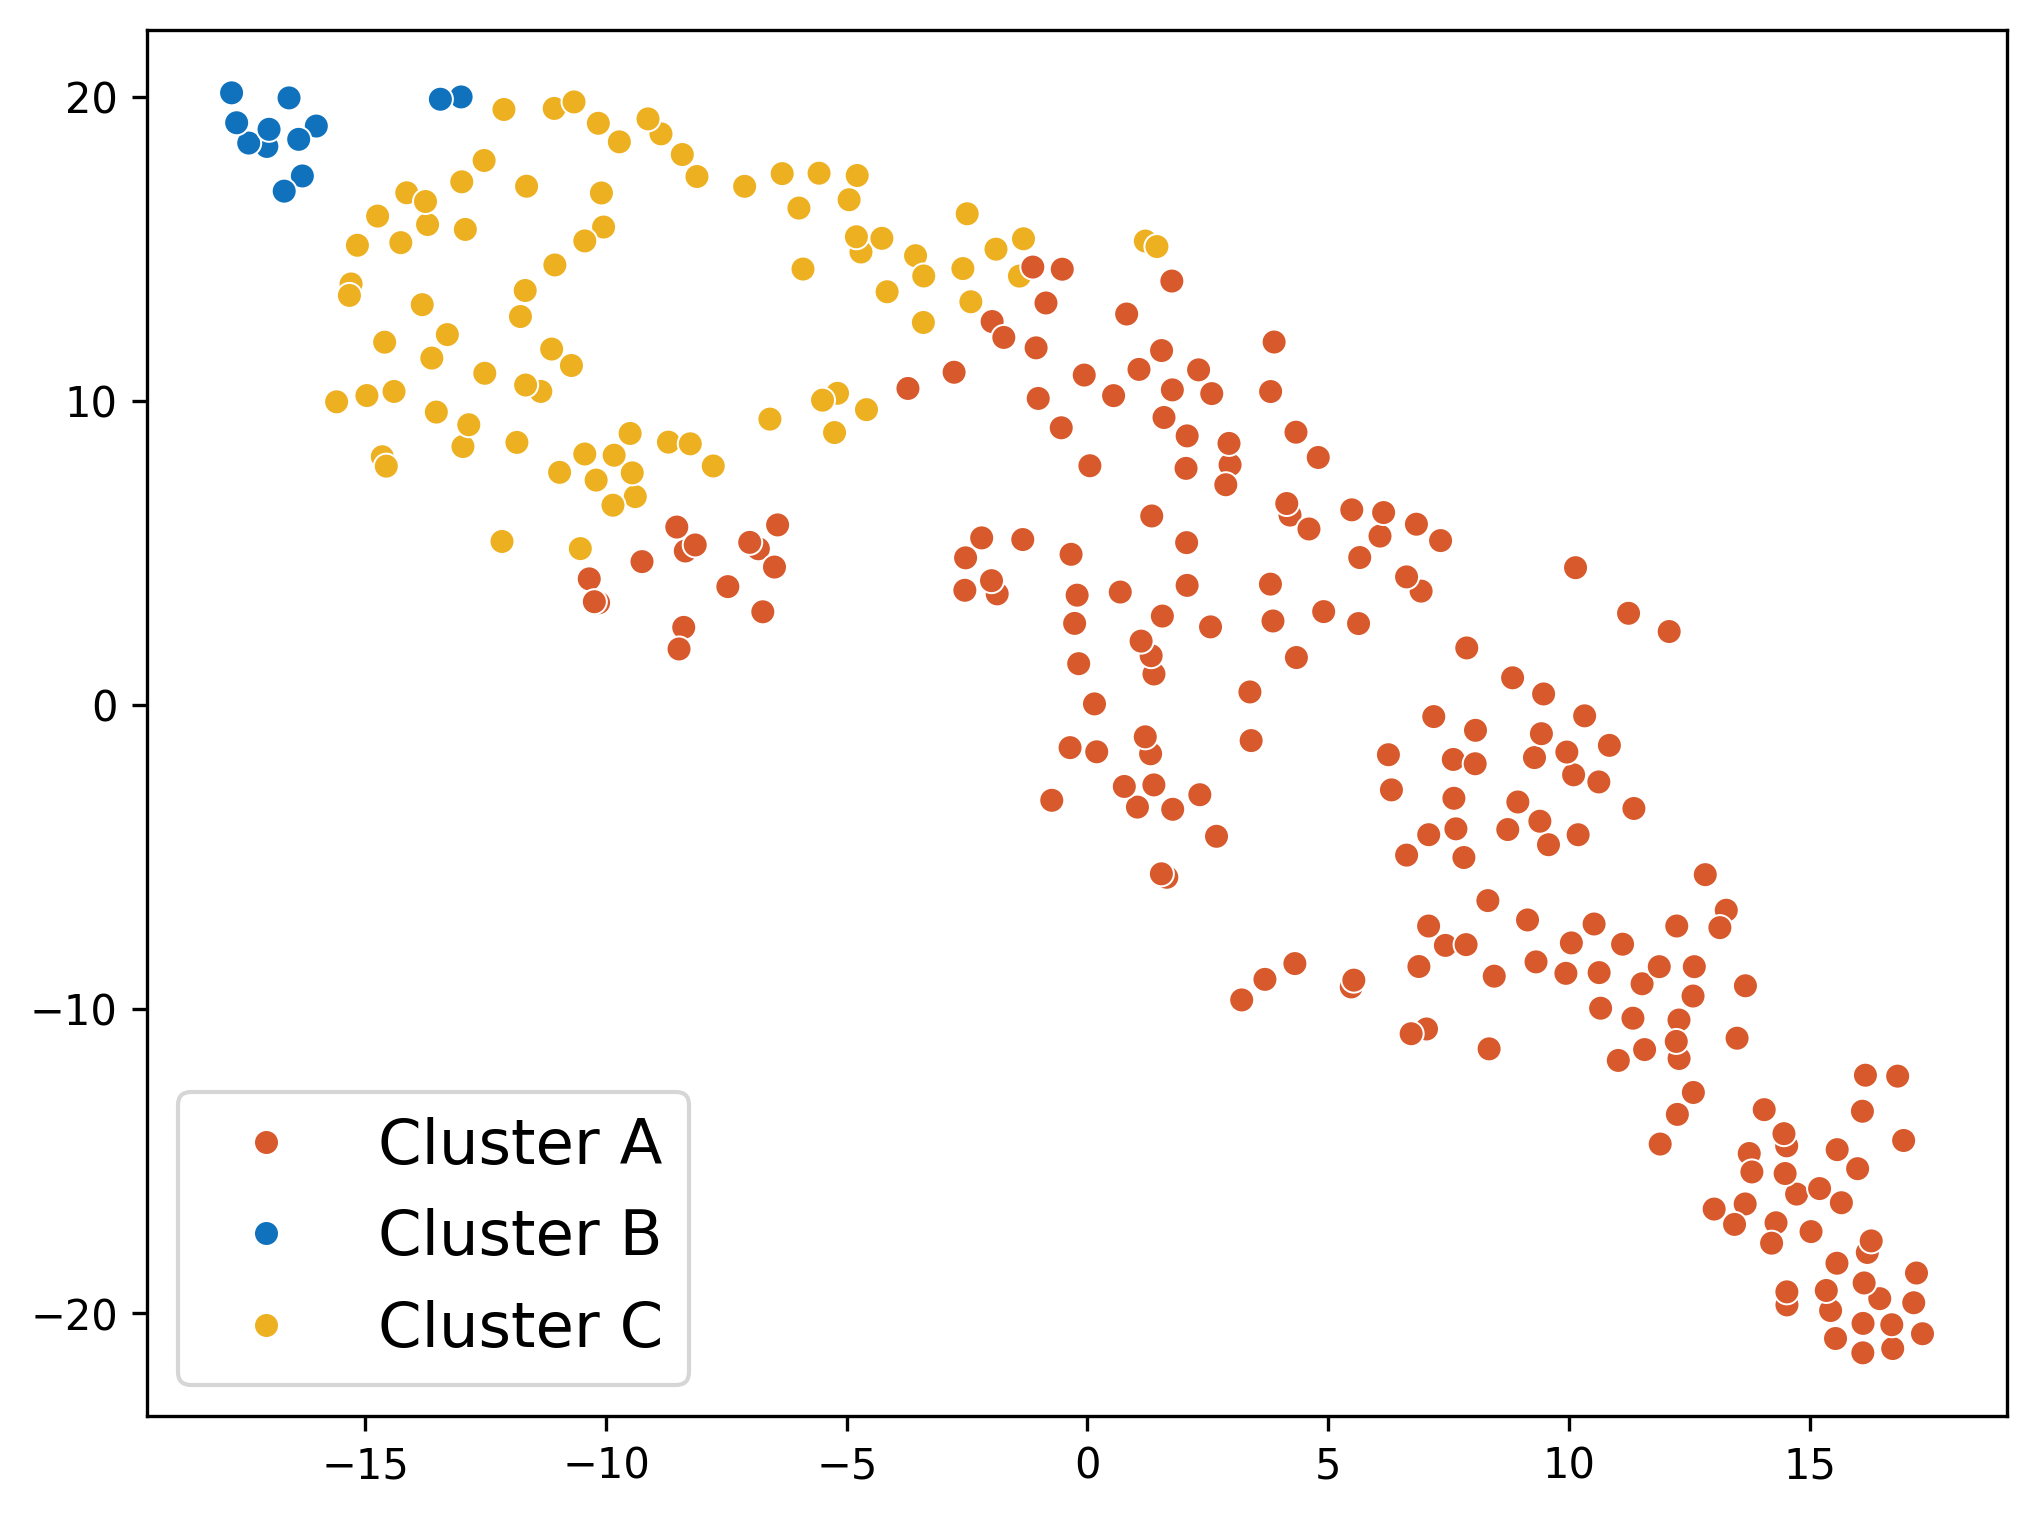

In [7]:
cluster_labels = ClusterAndVis(featureResult)

In [ ]:
def displayOnMap(cluster_labels):
    adj_mat = np.zeros((len(stationID_List), len(stationID_List)))
    for line in stationInfo.values:
        stationID = line[1]#找到此次循环的站点ID
        station_idx = stationID_List.index(stationID)#找到该站点ID在stationID_List中的索引
        neighbor_stationIDList = eval(line[-1])#邻接站点列表
        for neighbor in neighbor_stationIDList:
            if neighbor in stationID_List:
                neighbor_idx = stationID_List.index(neighbor)
                adj_mat[station_idx][neighbor_idx] = 1
                adj_mat[neighbor_idx][station_idx] = 1
    map_center = (np.mean(stationInfo["lat"]), np.mean(stationInfo["lon"]))  
    m = folium.Map(location=map_center, zoom_start=12, tiles='CartoDB positron')
    color_palette=['#D7592C','#1072BD','#EDB021']

    for i in range(len(stationID_List)):
        for j in range(i+1, len(stationID_List)):
            if adj_mat[i,j]==1:#邻接站点
                startID = stationID_List[i]
                endID = stationID_List[j]
                start_loc = (dict_stationLoc[startID][1],dict_stationLoc[startID][0])
                end_loc = (dict_stationLoc[endID][1],dict_stationLoc[endID][0])
                folium.PolyLine([start_loc, end_loc], color="grey", weight=3, opacity=0.5).add_to(m)

    index = 0
    for node, loc in dict_stationLoc.items():
        loc = (loc[1], loc[0])
        node_name = dict_staionName[node]
        clusterOutcome = cluster_labels[index]
        folium.CircleMarker(location=loc,popup=node_name, radius=4, color=color_palette[clusterOutcome], fill=True).add_to(m)
        index += 1

    return m

In [23]:
displayOnMap(cluster_labels)

In [10]:
# def fetchData(targetStationID = 508, start_date = "2017-05-13", end_date = "2017-05-26"):
#     timeslotPerDay = 17*6
#     zero_date = '2017-05-01'
    
#     start_slot = (datetime.datetime.strptime(start_date,"%Y-%m-%d")-datetime.datetime.strptime(zero_date,"%Y-%m-%d")).days * timeslotPerDay
#     end_slot = ((datetime.datetime.strptime(end_date,"%Y-%m-%d")-datetime.datetime.strptime(zero_date,"%Y-%m-%d")).days+1) * timeslotPerDay -1
#     #print(start_slot, end_slot)


#     Container = []
#     tmp =[]

#     for padding in range(6*6): # Initial 0-6 A.M.
#         Container.append([0]*8)

#     for iter in range(len(raw_data.values)):
#         line = raw_data.values[iter]
#         timeSlot = line[1]

#         if timeSlot < start_slot:
#             continue
        
#         if timeSlot > end_slot:
#             for padding in range(1*6): # Final 11-12 P.M.
#                 Container.append([0]*8)
#             break # get enough data

#         if line[4] == targetStationID:
#             Container.append(line[5:])
#             tmp.append(timeSlot)

#             if (timeSlot+1)%timeslotPerDay == 0 and timeSlot != end_slot:
#                 for padding in range(7*6):
#                     Container.append([0]*8)

#     Container = np.array(Container)
#     return Container


# def visStationFlow (Container, start_date = "2017-05-13", end_date = "2017-05-26"):
#     mydates = pd.date_range(start=datetime.datetime.strptime(start_date,"%Y-%m-%d"), end=datetime.datetime.strptime(end_date,"%Y-%m-%d")+datetime.timedelta(days=1), freq="10T")[:-1]

#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), dpi=300)

#     ax1.plot(mydates, Container[:,0], label='inFlow', linewidth=0.8, color=(26/255,8/255,65/255))
#     ax1.plot(mydates, Container[:,2], label='CinFlow', linewidth=0.8, color=(79/255,157/255,166/255))
#     ax1.plot(mydates, Container[:,3], label='HOinFlow', linewidth=0.8, color=(255/255,173/255,90/255))
#     ax1.plot(mydates, Container[:,4], label='WOinFlow', linewidth=0.8, color=(255/255,89/255,89/255))
#     ax1.set_title('Inflow of Station')
#     ax1.set_xlabel('Time')
#     ax1.set_ylabel('#Ridership')
#     ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:00'))  
#     ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))  
#     ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
#     ax1.legend(loc='upper left')
#     ax1.grid()

#     ax2.plot(mydates, Container[:,1], label='outFlow', linewidth=0.8, color=(26/255,8/255,65/255))
#     ax2.plot(mydates, Container[:,5], label='CoutFlow', linewidth=0.8, color=(79/255,157/255,166/255))
#     ax2.plot(mydates, Container[:,6], label='HOoutFlow', linewidth=0.8, color=(255/255,173/255,90/255))
#     ax2.plot(mydates, Container[:,7], label='WOoutFlow', linewidth=0.8, color=(255/255,89/255,89/255))
#     ax2.set_title('Outflow of Station')
#     ax2.set_xlabel('Time')
#     ax2.set_ylabel('#Ridership')
#     ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:00'))  
#     ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))  
#     ax2.set_xticklabels(ax1.get_xticklabels(),rotation=45)
#     ax2.legend(loc='upper left')
#     ax2.grid()

#     # 显示图形
#     plt.tight_layout()
#     plt.show()

In [11]:
# def drawClusterAvgTS(cluster_labels, clutserID, start_date, end_date):
#     indices = [index for index, value in enumerate(cluster_labels) if value == clutserID]
    
#     Container = []
#     for idx in tqdm(indices):
#         Container.append(fetchData(stationID_List[idx], start_date, end_date))
#     Container = np.array(Container)
#     Container = np.mean(Container,axis=0)
#     print(Container.shape)

#     return Container

In [12]:
# start_date = "2017-05-14"
# end_date = "2017-05-15"
# Container = drawClusterAvgTS(cluster_labels, 0, start_date, end_date)
# visStationFlow(Container, start_date, end_date)

In [13]:
def ExtractRefinedFeature():
    abnormal_date = [20170504, 20170508, 20170509, 20170616, 20170627, 20170628]
    featureWorkday = np.zeros((len(stationID_List), 17*2)) #[wordayinflow, workdayoutflow]
    featureNonWorkday = np.zeros((len(stationID_List), 17*2)) #[non-wordayinflow, non-workdayoutflow]
    workday_count = 0
    nonworkday_count = 0
    day_cache = 20170504

    for line in tqdm(raw_data.values):
        if line[0] in abnormal_date:
            continue 

        if line[0] != day_cache:
            day_cache = line[0]
            curr_date = datetime.datetime.strptime(str(line[0]),"%Y%m%d")
            if is_workday(curr_date):
                workday_count += 1
            else:
                nonworkday_count += 1
        
        curr_hour = line[2]//10000

        stationID = line[4]
        time_bins = curr_hour - 6 


        if is_workday(curr_date):
            featureWorkday[stationID_List.index(stationID), time_bins] += line[5]
            featureWorkday[stationID_List.index(stationID), time_bins + 17] += line[6]
        else:
            featureNonWorkday[stationID_List.index(stationID), time_bins] += line[5]
            featureNonWorkday[stationID_List.index(stationID), time_bins + 17] += line[6]
        
    featureWorkday = featureWorkday / workday_count
    featureNonWorkday = featureNonWorkday / nonworkday_count
    RefinedfeatureResult = np.concatenate((featureWorkday, featureNonWorkday), axis=1)
    print(RefinedfeatureResult.shape, workday_count, nonworkday_count)

    return RefinedfeatureResult

In [ ]:
def fetch_data_centriod(cluster_labels, featureResult):

    cluster_sample_container =[[] for _ in range(5)]

    for idx, label in enumerate(cluster_labels):
        cluster_sample_container[label].append(featureResult[idx])#这里用了先前的featureResult,这一步的作用是把同一类的站点的特征放在一起，
        #每一个cluster_sample_container（5个）均是簇类大小x68
    cluster_centroid = [np.mean(np.array(cluster_sample),axis=0) for cluster_sample in cluster_sample_container]
    #计算质心，每一个cluster_centroid（5个）均是1x68维的向量，每个特征的含义是前34个，每个点的工作日的每个小时特征，前17个为入站，后17个为出站，后34个是非工作日特征
    return cluster_centroid

def visualize_centriod(cluster_centroid):
    fig, axis = plt.subplots(2, 5 , dpi= 500, figsize=(40,12))
    name_list = ['A','B','C','D','E']
    ld = 4
    s_size = 10
    
    for row in range(2): # workday-nonworkday
        for col in range(5):
            base_tick = row * 34
            inflowData = cluster_centroid[col, base_tick:base_tick+17]
            outflowData = cluster_centroid[col, base_tick+17:base_tick+34]
            time_ticks = [str(i)+':00' for i in range(6, 23)]
            # 只在第一个子图中添加 label
            if col == 0:
                if row ==0:
                    axis[row, col].plot(time_ticks, inflowData, label='WorkdayInflow', c='#6A9BCB', marker='^',linewidth=ld, markersize=s_size)
                    axis[row, col].plot(time_ticks, outflowData, label='WorkdayOutflow', c='#CB5148', marker='o',linewidth=ld, markersize=s_size)
                else:
                    axis[row, col].plot(time_ticks, inflowData, label='NonWorkdayInflow', c='#F6C490', marker='^',linewidth=ld, markersize=s_size)
                    axis[row, col].plot(time_ticks, outflowData, label='NonWorkdayOutflow', c='#1DBDC6', marker='o',linewidth=ld, markersize=s_size)
            else:
                if row == 0:
                    axis[row, col].plot(time_ticks, inflowData, c='#6A9BCB', marker='^',linewidth=ld, markersize=s_size)
                    axis[row, col].plot(time_ticks, outflowData, c='#CB5148', marker='o',linewidth=ld, markersize=s_size)
                else:
                    axis[row, col].plot(time_ticks, inflowData, c='#F6C490', marker='^',linewidth=ld, markersize=s_size)
                    axis[row, col].plot(time_ticks, outflowData, c='#1DBDC6', marker='o',linewidth=ld, markersize=s_size)
            if row == 0:
                axis[row,col].set_ylim(100, 20000)
            else:
                axis[row,col].set_ylim(100, 10000)
                
            axis[row,col].grid()

            xticks_positions = time_ticks[::4] 
            axis[row,col].set_xticks(xticks_positions) 
            axis[row, col].yaxis.set_major_locator(MaxNLocator(nbins=5))
            axis[row, col].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
            axis[row, col].tick_params(axis='both', which='major', labelsize=20)
            axis[row, col].yaxis.get_offset_text().set_fontsize(15)  # 设置字体大小

            if row == 0:
                axis[row,col].set_title('Cluster '+name_list[col], fontsize=30)

    # fig.text(0.5, 0.04, 'Time of Day', ha='center', va='center', fontsize=14)  
    # fig.text(0.06, 0.5, 'Flow Count', ha='center', va='center', rotation='vertical', fontsize=14) 
    legend = fig.legend(loc='lower center', ncol=4, prop={'size': 25})
    plt.savefig('../results/cluster-avgTS.pdf', dpi=300)
    #plt.tight_layout()


In [15]:
RefinedfeatureResult = ExtractRefinedFeature()

100%|██████████| 3788892/3788892 [02:29<00:00, 25399.60it/s] 

(302, 68) 81 36


In [16]:
cluster_centroid = np.array(fetch_data_centriod(cluster_labels, RefinedfeatureResult))

In [45]:
visualize_centriod(cluster_centroid)

In [18]:
target_cluster = 4
target_station_IDList = []
target_station_NameList = []

for idx, label in enumerate(cluster_labels):
    if label == target_cluster:
        target_station_IDList.append(stationID_List[idx])
        target_station_NameList.append(dict_staionName[stationID_List[idx]])

print(len(target_station_IDList))
print(target_station_NameList)

32
['龙漕路', '浦电路', '宜山路', '江苏路', '曹杨路', '豫园', '延长路', '娄山关路', '东昌路', '张江高科', '金科路', '漕河泾开发区', '大世界', '桂林路', '打浦桥', '商城路', '西藏南路', '肇嘉浜路', '虹口足球场', '东安路', '金沙江路', '世纪大道', '蓝村路', '常熟路', '长寿路', '镇坪路', '黄陂南路', '上海体育馆', '陆家浜路', '漕宝路', '汉中路', '虹桥路']
